In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.stats import pearsonr
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy import stats
from scipy.signal import convolve,deconvolve
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
import warnings
import matplotlib.cbook
import string
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ 'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'PROGESTERONE'           :'P4'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names = [x[:3] for x in calendar.month_name[1:13]]
letters     = string.ascii_uppercase

In [2]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]

#     zf = df.loc[df['age_group'] !='[70,80]'].copy()
#     zf = zf.loc[zf['age_group'] !='[60,70)']
#     zf = zf.loc[zf['age_group'] !='[50,60)'] 
#     # use ages 20-50 if there are more than 10k mesurements, if there are less, use ages 20-80
#     if np.sum(zf['n'].values)>10000:
#         df = zf

    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp*2,np.pi,maxamp*2,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        

        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))

        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars))
                
        elif hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars)) 
        else:
            all_tests_acrophase  .append(get_acrophase(pars))
            all_tests_relmaxmin  .append(get_relmaxmin(pars))  

        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    print(all_tests_acrophase)
    print([aic1,aic2,aic_null])
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

--------------
CORTISOL_BLOOD female


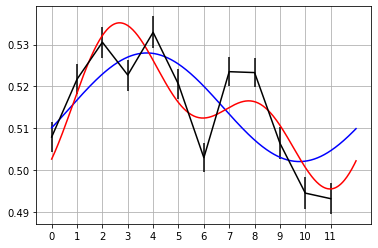

[3.41232099 1.04445892]
[-107.181980240139, -106.972528001746, -104.342324449896]
1st order cosinor
acrophase =  3.4123209904782166
maxmin/2 =  0.021260323075987447
--------------
CORTISOL_BLOOD male


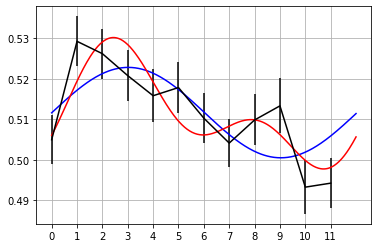

[1.62309596 1.00580589]
[-111.743453057460, -110.307777638560, -108.577902052602]
1st order cosinor
acrophase =  1.623095956005219
maxmin/2 =  0.02084031037993041
--------------
CORTISOL_BLOOD both


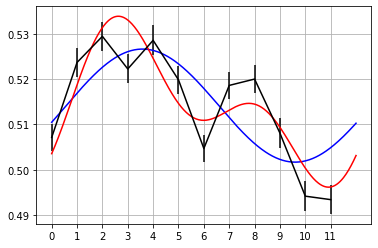

[2.76243325 1.11072941]
[-110.145552493843, -111.793910249907, -106.436221421503]
2nd order cosinor
acrophase =  2.7624332455808767
maxmin/2 =  0.019564459763485333
--------------
CORTISOL_U_FREE_24h female


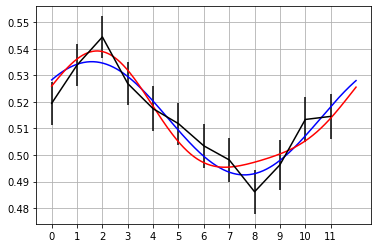

[1.88281454 0.49826451]
[-120.478728014386, -109.854457849766, -99.5918064853964]
1st order cosinor
acrophase =  1.8828145429540515
maxmin/2 =  0.030748893919823828
--------------
CORTISOL_U_FREE_24h male


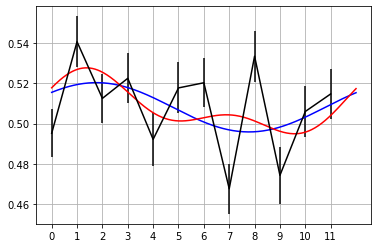

[0.8827854  2.80936113]
[-88.7255920434158, -80.4022878361597, -92.4818509780920]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
CORTISOL_U_FREE_24h both


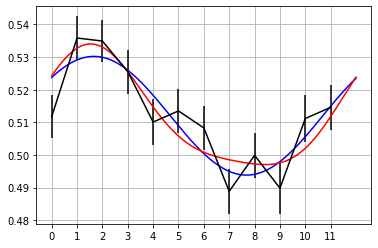

[1.56905512 0.66782475]
[-114.895632258583, -106.069794547013, -101.808756319585]
1st order cosinor
acrophase =  1.5690551178345014
maxmin/2 =  0.02718606918550057
--------------
T3_FREE female


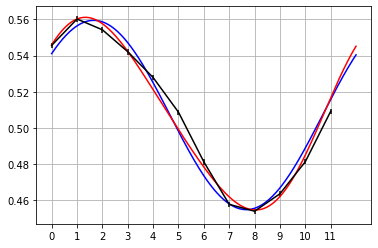

[1.00191037 0.04417392]
[-117.918240802452, -114.301529011443, -78.9045012281545]
1st order cosinor
acrophase =  1.0019103705623913
maxmin/2 =  0.053269888272171335
--------------
T3_FREE male


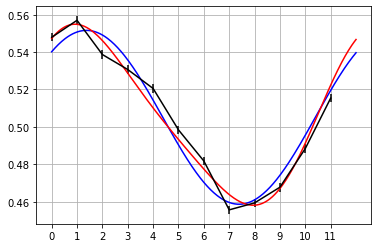

[0.99808963 0.04417392]
[-112.921866472758, -111.029918100508, -81.5183082604548]
1st order cosinor
acrophase =  0.9980896294376082
maxmin/2 =  0.05080406354627928
--------------
T3_FREE both


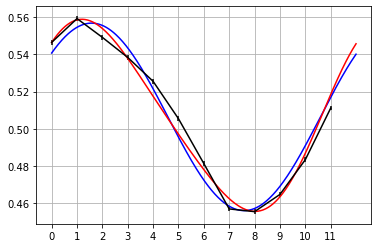

[ 1. -0.]
[-116.539596217890, -113.764060765806, -79.8093152246680]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05192811791227291
--------------
T4_FREE female


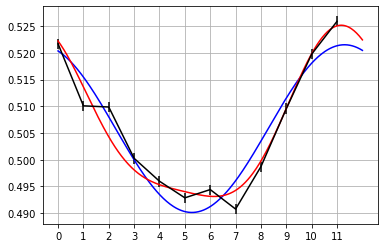

[11.00191037  0.04417392]
[-131.072154491035, -131.387389136684, -107.071202883704]
2nd order cosinor
acrophase =  11.00191037056239
maxmin/2 =  0.01758408684843189
--------------
T4_FREE male


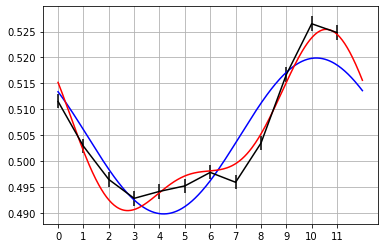

[10.17762694  0.38534067]
[-123.515271121924, -131.950104712241, -106.995155074175]
2nd order cosinor
acrophase =  10.177626939311207
maxmin/2 =  0.0170958951073319
--------------
T4_FREE both


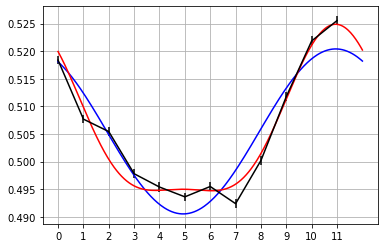

[1.10000000e+01 4.02472757e-08]
[-129.265485012136, -133.571789626239, -107.978050893905]
2nd order cosinor
acrophase =  10.999999999999998
maxmin/2 =  0.01664139160614954
--------------
ESTRADIOL_E_2 female


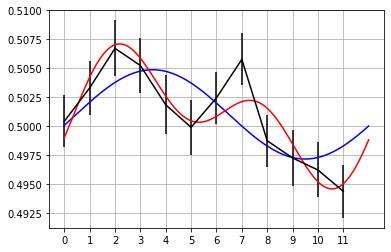

[2.23654976 0.58340063]
[-137.112857588213, -140.961201357866, -134.100973482634]
2nd order cosinor
acrophase =  2.236549763656665
maxmin/2 =  0.007284530197499689
--------------
ESTRADIOL_E_2 male


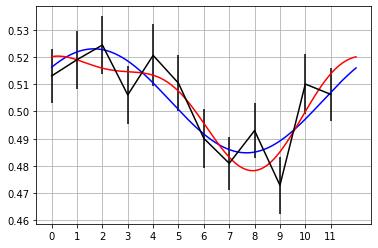

[2.12516535 1.58614393]
[-108.710891837413, -101.420279819293, -99.9551408258750]
1st order cosinor
acrophase =  2.125165346663789
maxmin/2 =  0.031148420889370882
--------------
ESTRADIOL_E_2 both


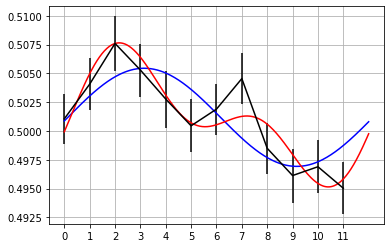

[2.2590947  1.26028992]
[-139.760756793523, -142.689349526942, -133.970110209824]
2nd order cosinor
acrophase =  2.2590946971081074
maxmin/2 =  0.007304830206098218
--------------
TESTOSTERONE_TOTAL female


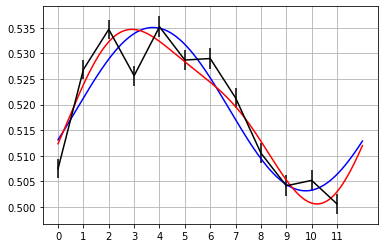

[3.1863662 1.0205508]
[-124.123835626609, -119.222748791575, -105.880631979792]
1st order cosinor
acrophase =  3.1863662010632203
maxmin/2 =  0.017794056349540156
--------------
TESTOSTERONE_TOTAL male


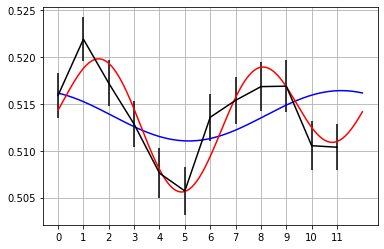

[1.06826107 0.31757831]
[-126.979061181808, -136.406695649289, -130.311000959419]
2nd order cosinor
acrophase =  1.0682610677894206
maxmin/2 =  0.00884074258314918
--------------
TESTOSTERONE_TOTAL both


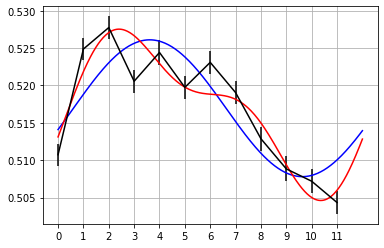

[2.06872925 0.71405823]
[-127.980606486650, -128.460969123683, -117.436405945897]
2nd order cosinor
acrophase =  2.0687292502833863
maxmin/2 =  0.011828037776091071
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female


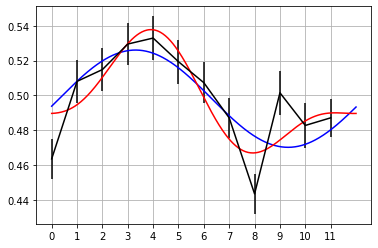

[3.63076127 0.85916668]
[-93.1684976356586, -88.1895372126725, -88.0971770341953]
1st order cosinor
acrophase =  3.6307612700812926
maxmin/2 =  0.04868202186730999
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male


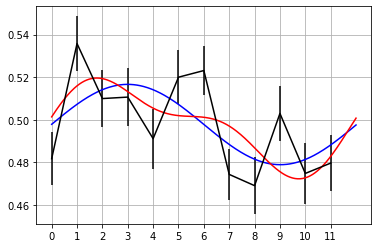

[1.85262024 2.08473556]
[-92.3039240557518, -84.0450433521442, -92.3538755231639]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both


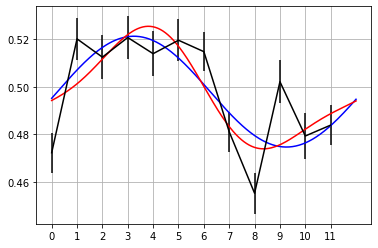

[3.423057   1.75894494]
[-96.9027322667331, -88.9741955444950, -92.1025753504068]
1st order cosinor
acrophase =  3.4230570038054084
maxmin/2 =  0.037159917447494084



--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE female


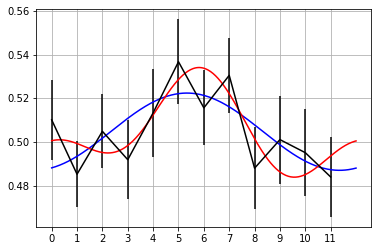

[5.5767037  1.45357191]
[-100.127187067170, -94.2268803662983, -98.4421512818690]
1st order cosinor
acrophase =  5.576703695264757
maxmin/2 =  0.040827770960308755
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE male


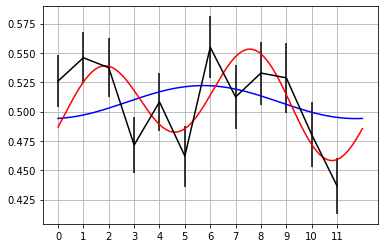

[6.01668328 3.23995509]
[-74.5555236540625, -72.7112514622068, -80.0876181091522]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE both


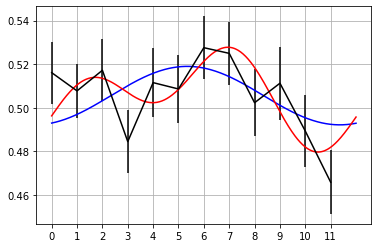

[6.12897008 2.4898122 ]
[-95.4344647607969, -91.9454027211177, -97.7402496406848]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TSH_THYROID_STIMULATING_HORMONE female


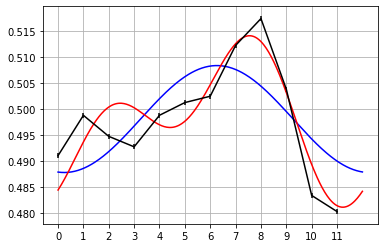

[8.00000000e+00 4.02472757e-08]
[-113.002995756856, -116.486059662476, -109.999914028207]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.01849969436049421
--------------
TSH_THYROID_STIMULATING_HORMONE male


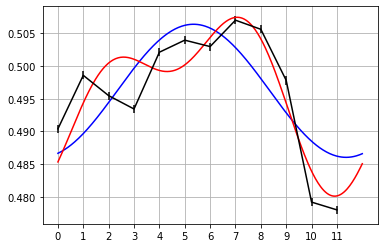

[7.04999329 0.22022952]
[-118.233708296522, -118.798691917333, -112.506963900193]
2nd order cosinor
acrophase =  7.04999328731738
maxmin/2 =  0.01454558506391026
--------------
TSH_THYROID_STIMULATING_HORMONE both


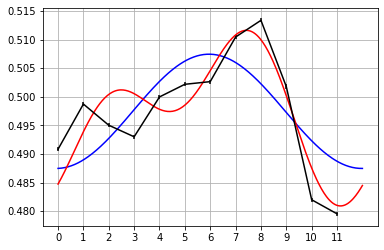

[8.00000000e+00 4.02472757e-08]
[-114.859140246059, -117.511190033894, -111.263706709037]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.016919093002619387
--------------
LH_LUTEINIZING_HORMONE female


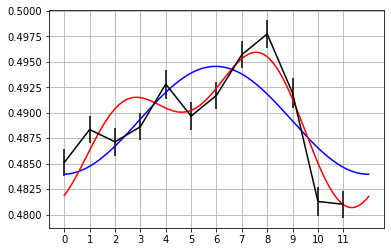

[7.84247838 0.41482182]
[-131.960906055173, -132.988498647955, -127.405535941342]
2nd order cosinor
acrophase =  7.842478379923616
maxmin/2 =  0.008772746066199445
--------------
LH_LUTEINIZING_HORMONE male


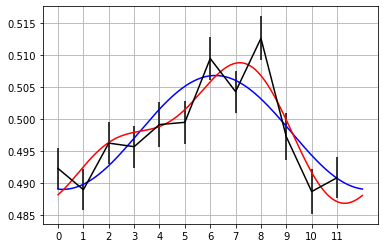

[7.473433   0.89209329]
[-126.829287059802, -123.055901045285, -117.884174925870]
1st order cosinor
acrophase =  7.473432996033521
maxmin/2 =  0.013503309549666078
--------------
LH_LUTEINIZING_HORMONE both


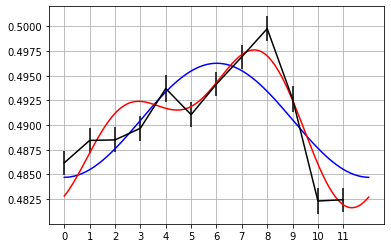

[7.94274617 0.24292813]
[-132.684866697322, -134.118507687993, -126.579748506596]
2nd order cosinor
acrophase =  7.942746171937289
maxmin/2 =  0.009064946393396724
--------------
FSH_FOLLICLE_STIMULATING_HORMONE female


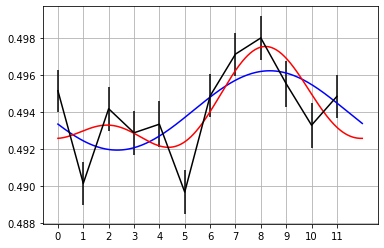

[7.78840104 0.87561639]
[-145.659679428050, -139.832645307986, -145.209481342774]
1st order cosinor
acrophase =  7.7884010428958
maxmin/2 =  0.004567915231993137
--------------
FSH_FOLLICLE_STIMULATING_HORMONE male


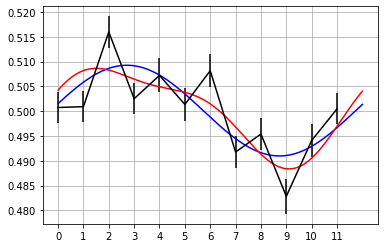

[2.13982668 0.76209259]
[-121.024867624366, -113.761217723230, -115.343809517184]
1st order cosinor
acrophase =  2.1398266806412902
maxmin/2 =  0.016809718392563015
--------------
FSH_FOLLICLE_STIMULATING_HORMONE both


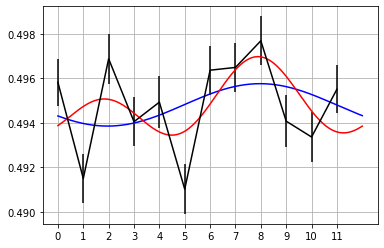

[7.51693804 2.22006174]
[-144.725363897284, -138.220777136956, -149.176638468277]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH female


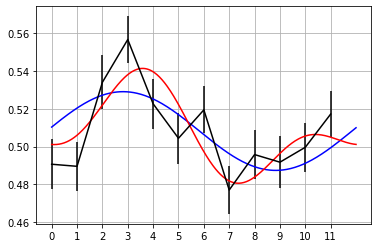

[2.94318669 0.5022631 ]
[-93.1350372134286, -88.8479785584909, -92.1356241127114]
1st order cosinor
acrophase =  2.943186685537946
maxmin/2 =  0.043724829408430324
--------------
GROWTH_HORMONE_GH male


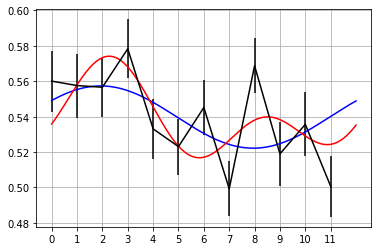

[2.40473193 2.46552581]
[-86.2979404725683, -80.7414874147564, -88.8639456461617]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH both


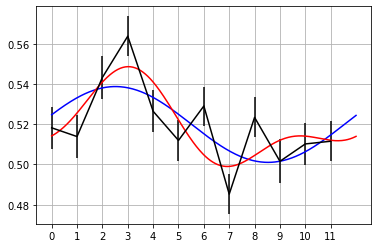

[2.90916031 0.29017308]
[-96.5840244966667, -90.9123069055858, -94.9042215977621]
1st order cosinor
acrophase =  2.909160312836266
maxmin/2 =  0.04050985808496967
--------------
PROLACTIN female


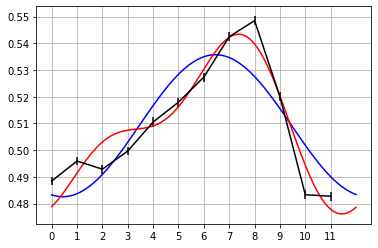

[7.99808963 0.04417392]
[-104.114635286407, -107.132231939434, -92.2351578176940]
2nd order cosinor
acrophase =  7.998089629437606
maxmin/2 =  0.0331541969496369
--------------
PROLACTIN male


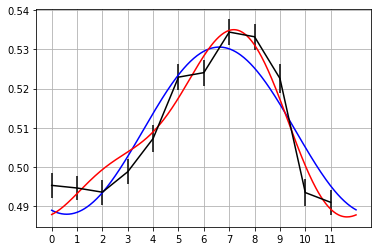

[7.42398686 0.50103899]
[-117.113680566696, -115.577934322436, -98.9350105404431]
1st order cosinor
acrophase =  7.423986863147961
maxmin/2 =  0.023300167101341272
--------------
PROLACTIN both


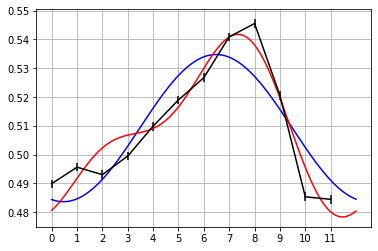

[7.99235241 0.08811696]
[-106.466312451544, -109.037284188367, -93.5302258279702]
2nd order cosinor
acrophase =  7.992352406896756
maxmin/2 =  0.03081513292003857



In [3]:
# effector_list  = gen_hormone_list(effector_hormone_dic)
# pituitary_list = gen_hormone_list(pituitary_hormone_dic)

--------------
ALDOSTERONE_BLOOD female


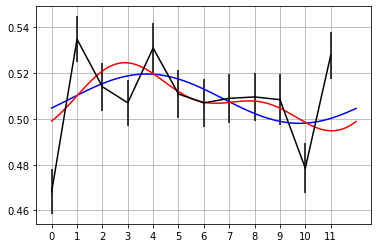

[1.57011224 2.07733505]
[-92.0775538543886, -83.7982636377193, -95.6634057071109]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD male


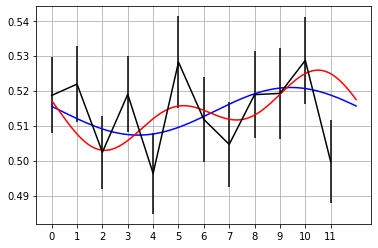

[9.36049762 3.77659242]
[-104.069895888838, -94.0349580164529, -109.416878781560]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD both


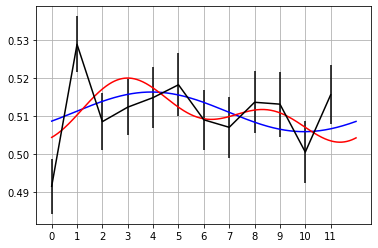

[1.37081085 2.07682784]
[-109.158327712615, -100.445056186152, -113.589875521363]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANDROSTENEDIONE female


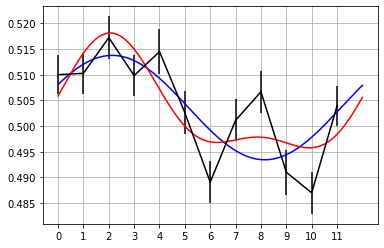

[2.44737258 1.16152012]
[-115.684305102429, -109.611432891347, -111.691098826834]
1st order cosinor
acrophase =  2.4473725772368193
maxmin/2 =  0.016956739525035087
--------------
ANDROSTENEDIONE male


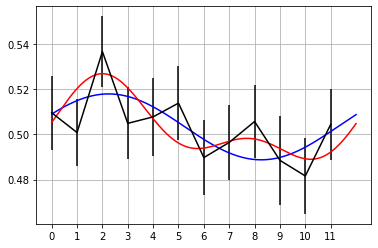

[2.15309118 1.62591204]
[-103.921142601225, -95.3582975193980, -103.179030493502]
1st order cosinor
acrophase =  2.153091182262949
maxmin/2 =  0.036839778914165774
--------------
ANDROSTENEDIONE both


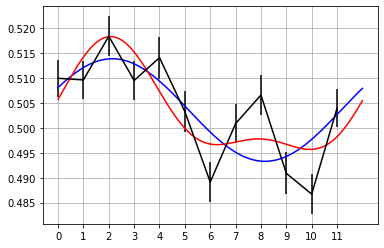

[2.30790715 0.93767192]
[-115.418849079368, -109.257236113541, -111.389427819556]
1st order cosinor
acrophase =  2.3079071515387772
maxmin/2 =  0.017254066610253423
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME female


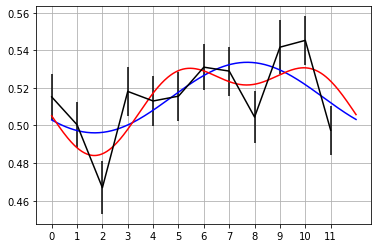

[9.20043727 1.42891561]
[-93.5785931188094, -87.4850319907421, -93.3152882191962]
1st order cosinor
acrophase =  9.200437273348845
maxmin/2 =  0.04321132327170702
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME male


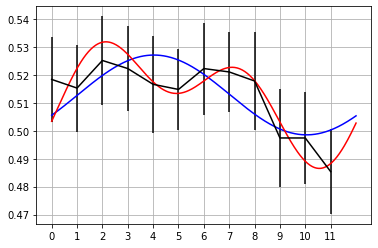

[3.92130018 3.07174396]
[-108.935009795840, -107.836818985245, -106.289032618377]
1st order cosinor
acrophase =  3.9213001785997332
maxmin/2 =  0.03373974958279348
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME both


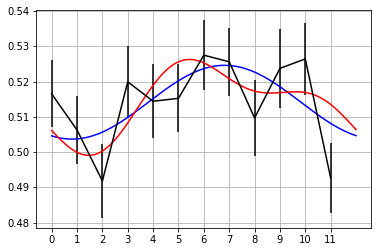

[7.63846524 2.35970998]
[-106.296389460974, -97.4396587234065, -106.799345111923]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
DHEA_SULPHATE female


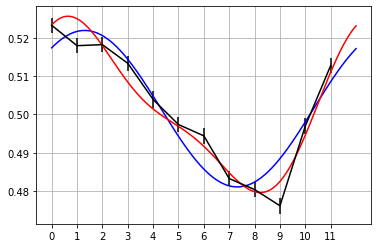

[0.0655129  0.33097386]
[-120.887677537341, -122.629401189560, -100.344558490949]
2nd order cosinor
acrophase =  0.06551290054832185
maxmin/2 =  0.023622850176844696
--------------
DHEA_SULPHATE male


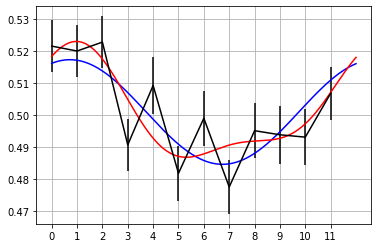

[1.13809195 1.04806201]
[-107.612217607836, -100.590180561999, -101.532073130224]
1st order cosinor
acrophase =  1.1380919480962168
maxmin/2 =  0.027182784913499916
--------------
DHEA_SULPHATE both


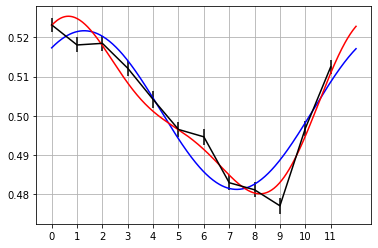

[0.07877148 0.37521105]
[-121.779435691101, -123.822129201916, -100.712588153344]
2nd order cosinor
acrophase =  0.07877148391740268
maxmin/2 =  0.02315813253157771
--------------
PARATHYROID_HORMONE_PTH female


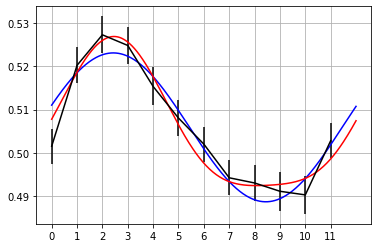

[2.25951527 0.53792008]
[-129.010707660968, -125.879467664416, -104.866770787832]
1st order cosinor
acrophase =  2.259515269616889
maxmin/2 =  0.020633948180321913
--------------
PARATHYROID_HORMONE_PTH male


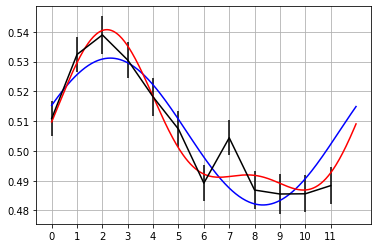

[2.00638331 0.57109323]
[-110.384462369175, -112.989699621956, -95.0597961339820]
2nd order cosinor
acrophase =  2.006383309898525
maxmin/2 =  0.03048697663942601
--------------
PARATHYROID_HORMONE_PTH both


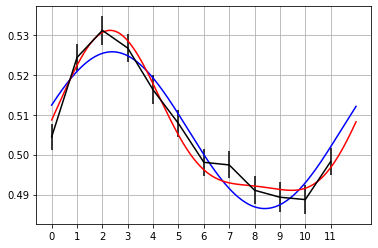

[2.08268982 0.4684795 ]
[-125.485039875282, -130.034508180533, -101.724455779819]
2nd order cosinor
acrophase =  2.082689823314335
maxmin/2 =  0.022549655317100202
--------------
17_HYDROXY_PROGESTERONE female


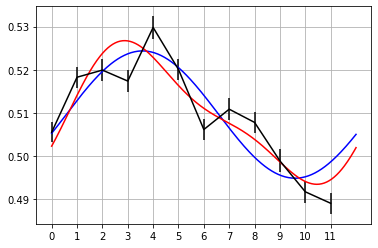

[3.99860011 0.09619645]
[-119.247005388944, -114.207988997136, -106.653570745386]
1st order cosinor
acrophase =  3.998600111207091
maxmin/2 =  0.020676595104436687
--------------
17_HYDROXY_PROGESTERONE male


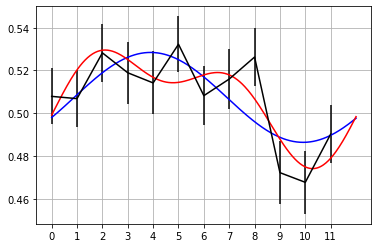

[4.55818712 2.52285393]
[-97.8688834071737, -94.0153200540925, -93.9776877027978]
1st order cosinor
acrophase =  4.55818711900088
maxmin/2 =  0.04010328829574901
--------------
17_HYDROXY_PROGESTERONE both


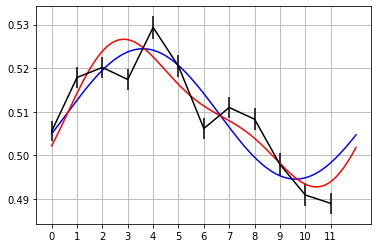

[3.99911114 0.14311659]
[-119.324048675262, -114.557376799345, -106.420847018778]
1st order cosinor
acrophase =  3.999111139039593
maxmin/2 =  0.020405322123246954
--------------
PROGESTERONE female


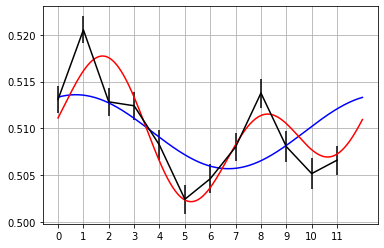

[ 1. -0.]
[-127.322649138321, -131.192551481676, -127.976531610612]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.009312427296940949
--------------
PROGESTERONE male


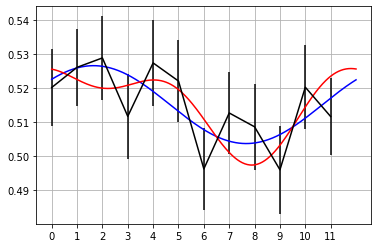

[2.37372884 2.21999933]
[-110.803094116512, -99.8155795854281, -109.131552138239]
1st order cosinor
acrophase =  2.373728842071859
maxmin/2 =  0.027072299109954748
--------------
PROGESTERONE both


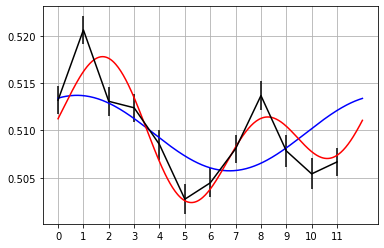

[ 1. -0.]
[-127.747045691670, -131.482232210358, -128.094386064820]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.009079218950221157



--------------
CALCIUM_BLOOD female


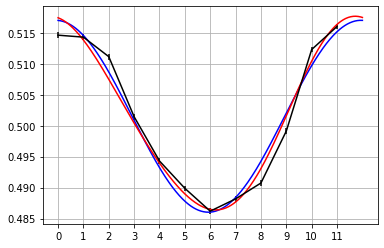

[11.03018693  0.1839363 ]
[-143.812430584191, -137.409725497171, -108.027636765460]
1st order cosinor
acrophase =  11.030186928506051
maxmin/2 =  0.014898399909376213
--------------
CALCIUM_BLOOD male


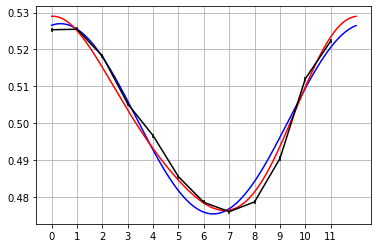

[0.58182913 0.49619657]
[-132.835834721447, -131.125778070514, -95.8090955496719]
1st order cosinor
acrophase =  0.5818291325082533
maxmin/2 =  0.024872018207116837
--------------
CALCIUM_BLOOD both


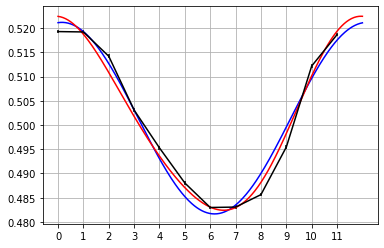

[0.41272288 0.57258446]
[-139.688955704988, -135.301848123680, -102.221633729650]
1st order cosinor
acrophase =  0.41272288136018187
maxmin/2 =  0.018316910912762826
--------------
CREATININE_BLOOD female


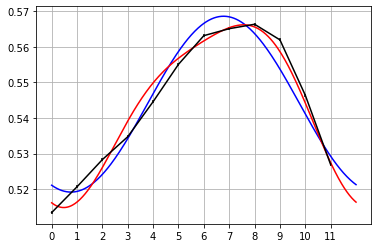

[7.99235241 0.08811696]
[-124.676813495220, -126.000704438035, -96.5010421366707]
2nd order cosinor
acrophase =  7.992352406896756
maxmin/2 =  0.026437674965357785
--------------
CREATININE_BLOOD male


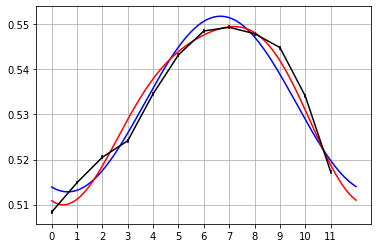

[6.93247716 0.26846793]
[-131.553113514915, -128.928935389480, -102.300932423498]
1st order cosinor
acrophase =  6.932477162707147
maxmin/2 =  0.020463493912149334
--------------
CREATININE_BLOOD both


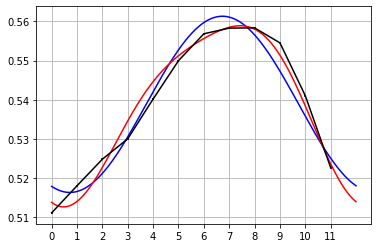

[7.58182913 0.49619657]
[-127.645376940915, -127.379213896154, -98.7898448303869]
1st order cosinor
acrophase =  7.581829132508253
maxmin/2 =  0.023648367743508678
--------------
Cl female


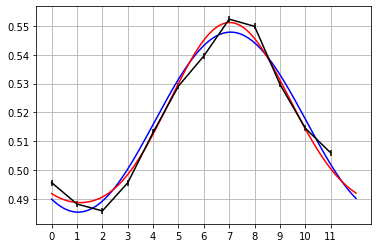

[7.02491355 0.15759142]
[-126.853452000716, -122.726763722742, -91.1919494026929]
1st order cosinor
acrophase =  7.024913545153331
maxmin/2 =  0.03327982328588065
--------------
Cl male


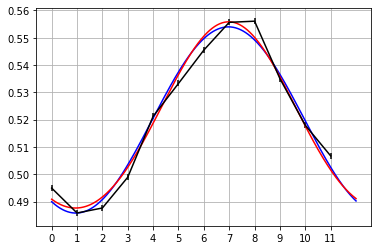

[7.60633301 0.49152471]
[-128.488074344943, -120.591595819116, -89.2217566987482]
1st order cosinor
acrophase =  7.606333007733219
maxmin/2 =  0.03535108682806442
--------------
Cl both


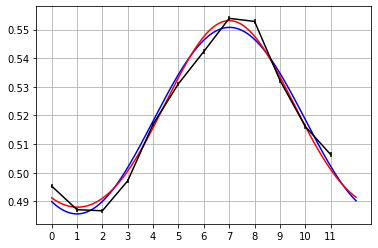

[7.15380837 0.36386581]
[-128.190454471918, -121.984479076877, -90.2611516989368]
1st order cosinor
acrophase =  7.15380837312469
maxmin/2 =  0.03377929481354557
--------------
GLUCOSE_BLOOD female


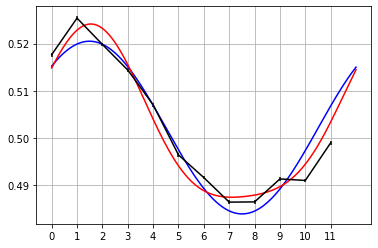

[ 1. -0.]
[-129.168172857597, -127.636596344799, -103.525797935776]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.0195458960947536
--------------
GLUCOSE_BLOOD male


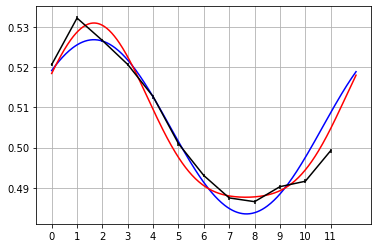

[ 1. -0.]
[-126.551610046500, -125.387869109663, -99.5868907066776]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.022839782527611388
--------------
GLUCOSE_BLOOD both


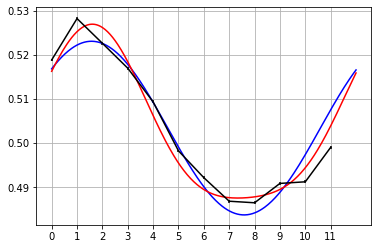

[ 1. -0.]
[-128.043068134123, -126.757397142993, -101.783884820443]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02090468855500761
--------------
HEMOGLOBIN_A1C_CALCULATED female


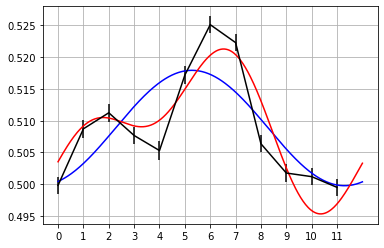

[6.05968211 0.23934692]
[-120.637715476562, -121.790469586038, -115.112233809179]
2nd order cosinor
acrophase =  6.059682110520742
maxmin/2 =  0.013221424167394196
--------------
HEMOGLOBIN_A1C_CALCULATED male


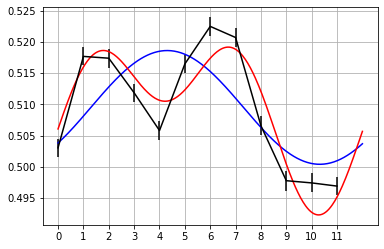

[6.18062196 0.53465052]
[-115.690619744159, -121.911294985172, -112.821320160754]
2nd order cosinor
acrophase =  6.1806219616371765
maxmin/2 =  0.013385868230867733
--------------
HEMOGLOBIN_A1C_CALCULATED both


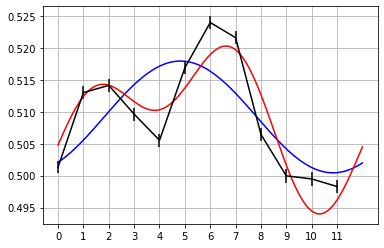

[6.05192918 0.22421504]
[-118.534948488563, -122.194090257618, -114.647212686230]
2nd order cosinor
acrophase =  6.051929181640913
maxmin/2 =  0.01295186729570505
--------------
HGB female


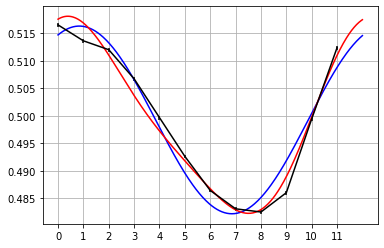

[ 0. -0.]
[-136.403487975931, -137.342143459340, -105.549781805471]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.016978822206364774
--------------
HGB male


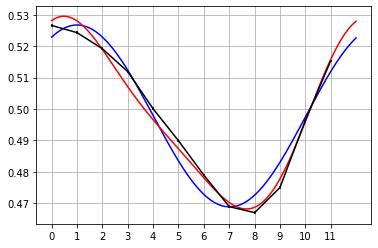

[ 0. -0.]
[-124.703083834958, -129.856606550229, -92.8634566114314]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.02981822136847148
--------------
HGB both


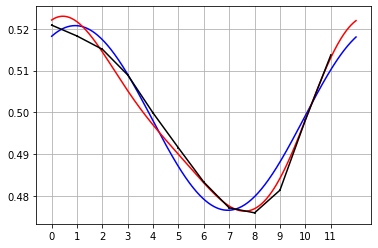

[ 0. -0.]
[-131.082214856896, -134.675528084645, -99.3431803764826]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.022462508567449434
--------------
MAGNESIUM_BLOOD female


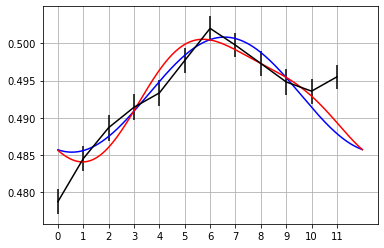

[6.15824588 0.46041071]
[-132.413662307044, -125.264135693955, -121.679680103194]
1st order cosinor
acrophase =  6.15824587893247
maxmin/2 =  0.01180130935701881
--------------
MAGNESIUM_BLOOD male


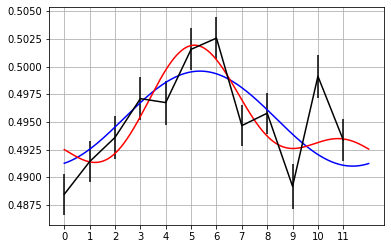

[5.65848677 0.83762285]
[-133.153113679397, -127.844708134024, -131.001604957416]
1st order cosinor
acrophase =  5.65848677327335
maxmin/2 =  0.007850352795891814
--------------
MAGNESIUM_BLOOD both


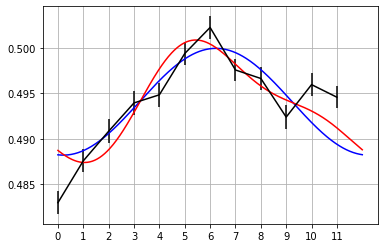

[5.93251368 0.26101782]
[-135.921685294508, -129.865674086645, -127.298984682758]
1st order cosinor
acrophase =  5.932513680001732
maxmin/2 =  0.009590993347159326
--------------
POTASSIUM female


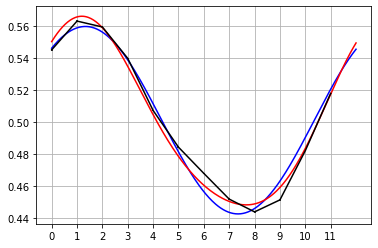

[ 1. -0.]
[-115.286429686624, -114.870804611102, -76.2386989006716]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05957806844800293
--------------
POTASSIUM male


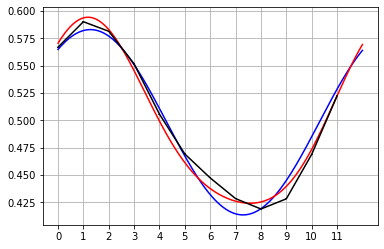

[ 1. -0.]
[-104.895235674047, -106.929650522215, -67.3147764748637]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.08563649833069432
--------------
POTASSIUM both


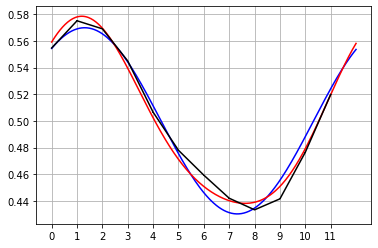

[ 1. -0.]
[-110.252793013091, -111.324389316518, -72.0091059337293]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.07083377765882966
--------------
SODIUM female


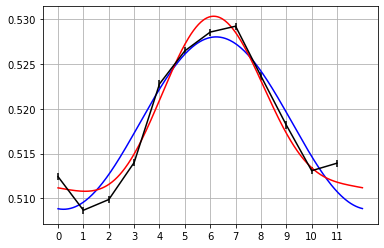

[6.88957279 0.31635085]
[-142.815365956598, -144.063838051385, -118.766385225814]
2nd order cosinor
acrophase =  6.889572791921137
maxmin/2 =  0.010305689531855932
--------------
SODIUM male


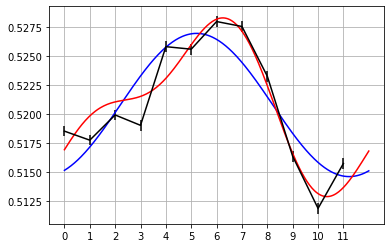

[6.25771738 0.44051118]
[-139.723555920607, -141.664070805082, -127.421878699155]
2nd order cosinor
acrophase =  6.257717375848594
maxmin/2 =  0.008108384855736225
--------------
SODIUM both


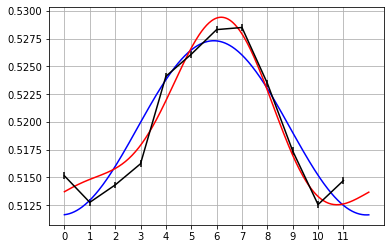

[6.66742226 0.47417603]
[-143.017742933674, -144.002400570584, -123.235051400571]
2nd order cosinor
acrophase =  6.667422263387284
maxmin/2 =  0.008059083681709092
--------------
UREA_BLOOD female


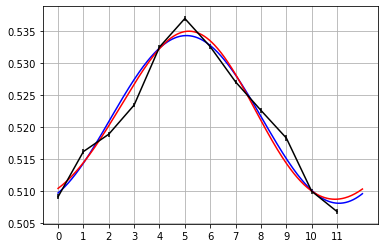

[ 5. -0.]
[-144.311990363565, -135.719975744382, -111.973558842047]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.015068081282333385
--------------
UREA_BLOOD male


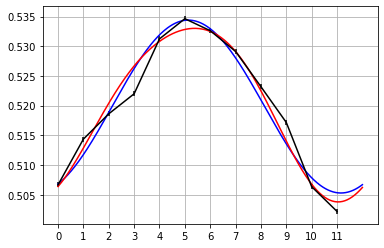

[ 5. -0.]
[-141.280434424696, -135.935682319724, -109.370615268171]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.016240558252713987
--------------
UREA_BLOOD both


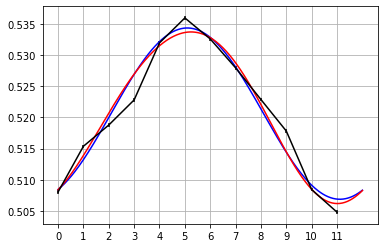

[ 5. -0.]
[-144.206030171298, -136.199965153684, -110.850095663245]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.015601251658340903



In [4]:
# residual_list  = gen_hormone_list(residual_hormone_dic)
# chem_list      = gen_hormone_list(chem_dic)

In [8]:
# pickle.dump([pituitary_list,effector_list,residual_list,chem_list],open('seasonality_processed_data0302_20_80.pickle','wb'))

--------------
TESTOSTERONE_TOTAL female


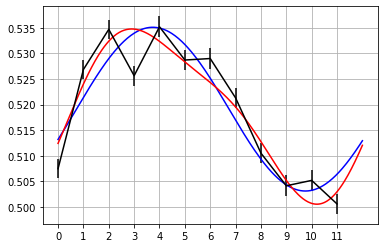

[3.1408841 1.014629 ]
[-124.045089933944, -119.118440365318, -105.880631979792]
1st order cosinor
acrophase =  3.1408840980036623
maxmin/2 =  0.01788921438415936
--------------
TESTOSTERONE_TOTAL male


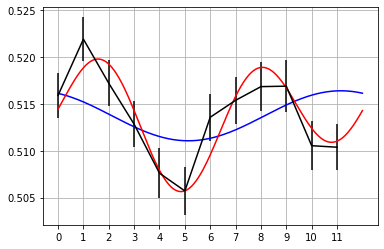

[1.04495438 0.34811442]
[-126.978684824395, -137.292869926042, -130.311000959419]
2nd order cosinor
acrophase =  1.0449543846512344
maxmin/2 =  0.008762442065276614
--------------
TESTOSTERONE_TOTAL both


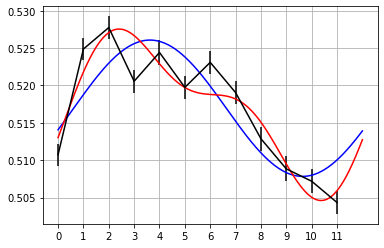

[1.98969615 0.56654065]
[-128.009506751978, -128.387856514234, -117.436405945897]
2nd order cosinor
acrophase =  1.9896961539117246
maxmin/2 =  0.011815661792664555
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female


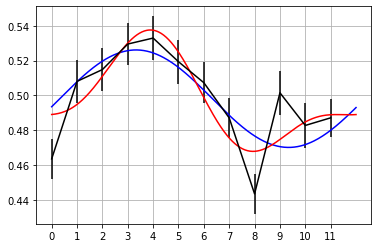

[3.67613185 0.89268943]
[-93.2051147851050, -88.4184169789024, -88.0971770341953]
1st order cosinor
acrophase =  3.676131849495247
maxmin/2 =  0.048109739563047406
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male


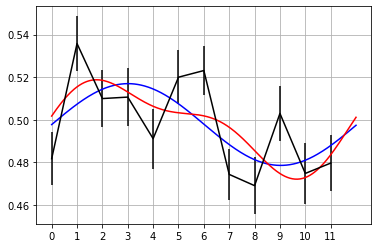

[1.88316794 2.17084007]
[-92.2998018962452, -84.2019932730755, -92.3538755231639]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both


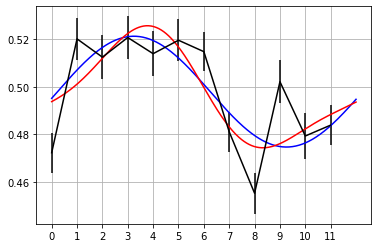

[3.16334634 1.71724918]
[-96.9047156732666, -89.0259883019285, -92.1025753504068]
1st order cosinor
acrophase =  3.1633463419731775
maxmin/2 =  0.037393856258274204
--------------
CALCIUM_BLOOD female


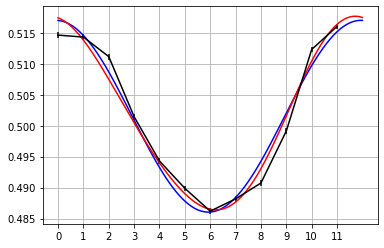

[11.02441146  0.16810154]
[-143.857222270007, -137.466752315362, -108.027636765460]
1st order cosinor
acrophase =  11.024411464434742
maxmin/2 =  0.014893490827518174
--------------
CALCIUM_BLOOD male


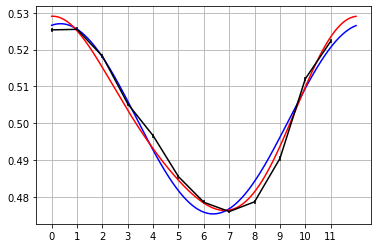

[0.59816854 0.49322184]
[-132.817633792047, -131.070303455182, -95.8090955496719]
1st order cosinor
acrophase =  0.5981685431955999
maxmin/2 =  0.02489117232084142
--------------
CALCIUM_BLOOD both


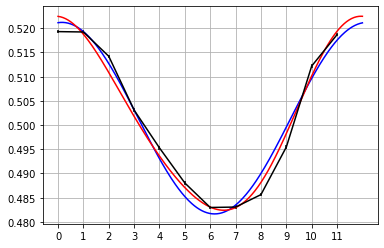

[0.41065703 0.57226553]
[-139.730915608530, -135.352023502065, -102.221633729650]
1st order cosinor
acrophase =  0.4106570250696524
maxmin/2 =  0.018315610218455795
--------------
CREATININE_BLOOD female


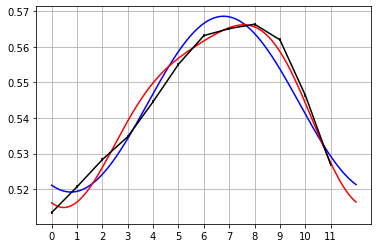

[7.98468863 0.12417781]
[-124.674313850739, -126.005169256564, -96.5010421366707]
2nd order cosinor
acrophase =  7.984688631451088
maxmin/2 =  0.02645364077829343
--------------
CREATININE_BLOOD male


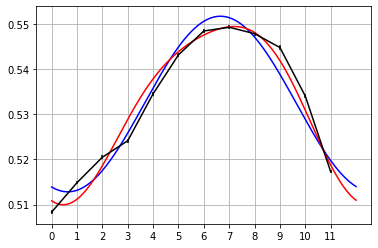

[6.9304932 0.2788038]
[-131.543398136403, -128.953322860401, -102.300932423498]
1st order cosinor
acrophase =  6.9304932023655565
maxmin/2 =  0.02047477814094463
--------------
CREATININE_BLOOD both


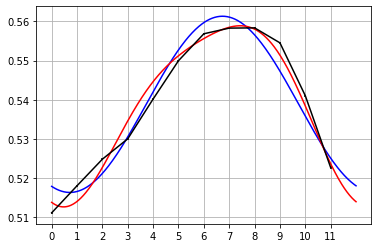

[7.55116228 0.50029112]
[-127.655939470346, -127.388622574193, -98.7898448303869]
1st order cosinor
acrophase =  7.55116228422173
maxmin/2 =  0.02364018471743421
--------------
GLUCOSE_BLOOD female


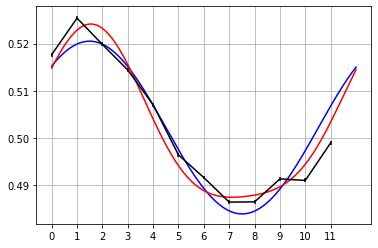

[ 1. -0.]
[-129.195309645960, -127.688967428493, -103.525797935776]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.019540938722468645
--------------
GLUCOSE_BLOOD male


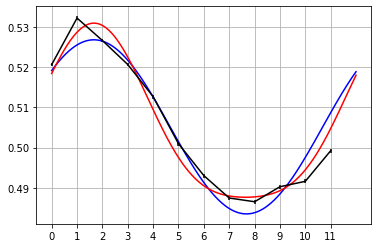

[ 1. -0.]
[-126.530531588883, -125.339298491541, -99.5868907066776]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.022819433732234683
--------------
GLUCOSE_BLOOD both


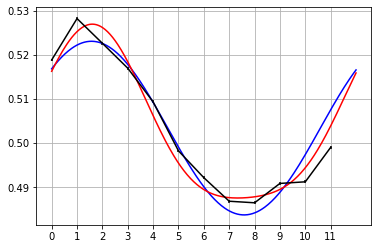

[ 1. -0.]
[-128.030278224657, -126.732266145152, -101.783884820443]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02090452961257545
--------------
HEMOGLOBIN_A1C_CALCULATED female


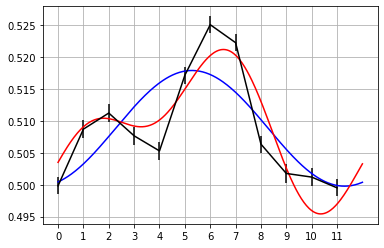

[6.06550653 0.24994643]
[-120.640457751144, -121.844220035884, -115.112233809179]
2nd order cosinor
acrophase =  6.065506533220145
maxmin/2 =  0.013125954666790354
--------------
HEMOGLOBIN_A1C_CALCULATED male


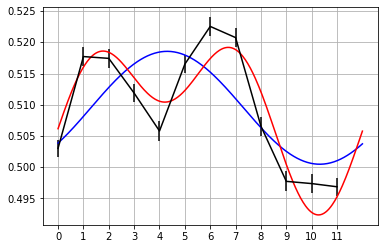

[6.17982597 0.48783694]
[-115.691426065757, -122.057585221397, -112.821320160754]
2nd order cosinor
acrophase =  6.179825971767537
maxmin/2 =  0.013312039820254654
--------------
HEMOGLOBIN_A1C_CALCULATED both


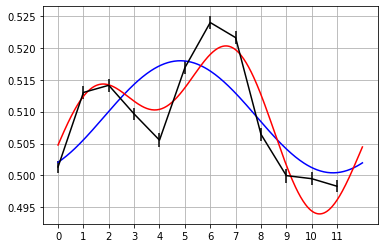

[6.04419127 0.20771301]
[-118.529424466094, -122.153921727282, -114.647212686230]
2nd order cosinor
acrophase =  6.044191268033662
maxmin/2 =  0.012985718198901314
--------------
HGB female


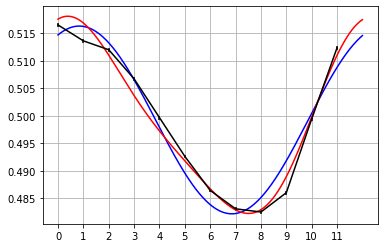

[ 0. -0.]
[-136.381275850565, -137.320932411715, -105.549781805471]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.017011750174090446
--------------
HGB male


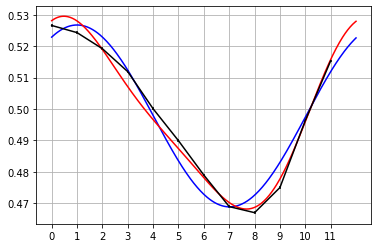

[0.00191037 0.04417392]
[-124.731266634105, -129.973494779912, -92.8634566114314]
2nd order cosinor
acrophase =  0.0019103705623914904
maxmin/2 =  0.029802824791552815
--------------
HGB both


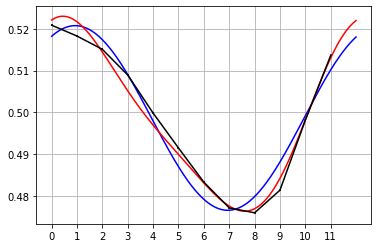

[ 0. -0.]
[-131.059051283379, -134.608451993875, -99.3431803764826]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.022466110592395304
--------------
UREA_BLOOD female


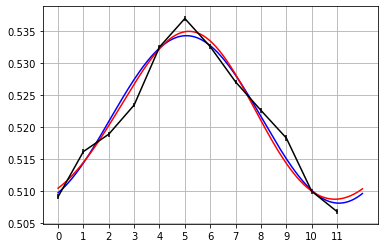

[ 5. -0.]
[-144.232827035489, -135.639021035875, -111.973558842047]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.0150455643510141
--------------
UREA_BLOOD male


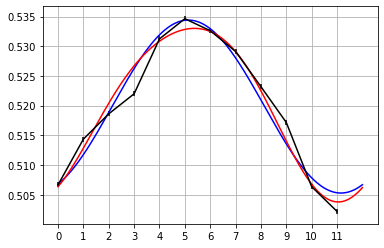

[ 5. -0.]
[-141.266352358886, -135.885740244249, -109.370615268171]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.016242819830230546
--------------
UREA_BLOOD both


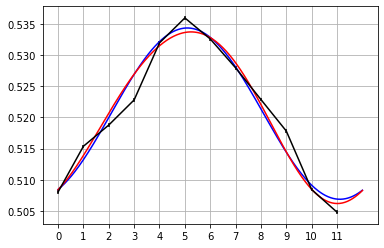

[ 5. -0.]
[-144.214326842112, -136.214592916809, -110.850095663245]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.015595099737940567



In [4]:
# clalit_ukb ={'TESTOSTERONE_TOTAL':'Testosterone',
#             'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF-1',
#             'CALCIUM_BLOOD':'Calcium',
#             'CREATININE_BLOOD':'Creatinine',
#             'GLUCOSE_BLOOD':'Glucose',
#             'HEMOGLOBIN_A1C_CALCULATED':'Glycated haemoglobin (HbA1c)',
#             'HGB':'Haemoglobin concentration',
#             'UREA_BLOOD':'Urea'}
# clalit_ukb_list  = gen_hormone_list(clalit_ukb)
# pickle.dump([clalit_ukb_list],open('seasonality_processed_data04_clalit_ukb.pickle','wb'))

In [4]:
[pituitary_list,effector_list,residual_list,chem_list] = pickle.load(open('seasonality_processed_data0302_20_80.pickle','rb'))

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


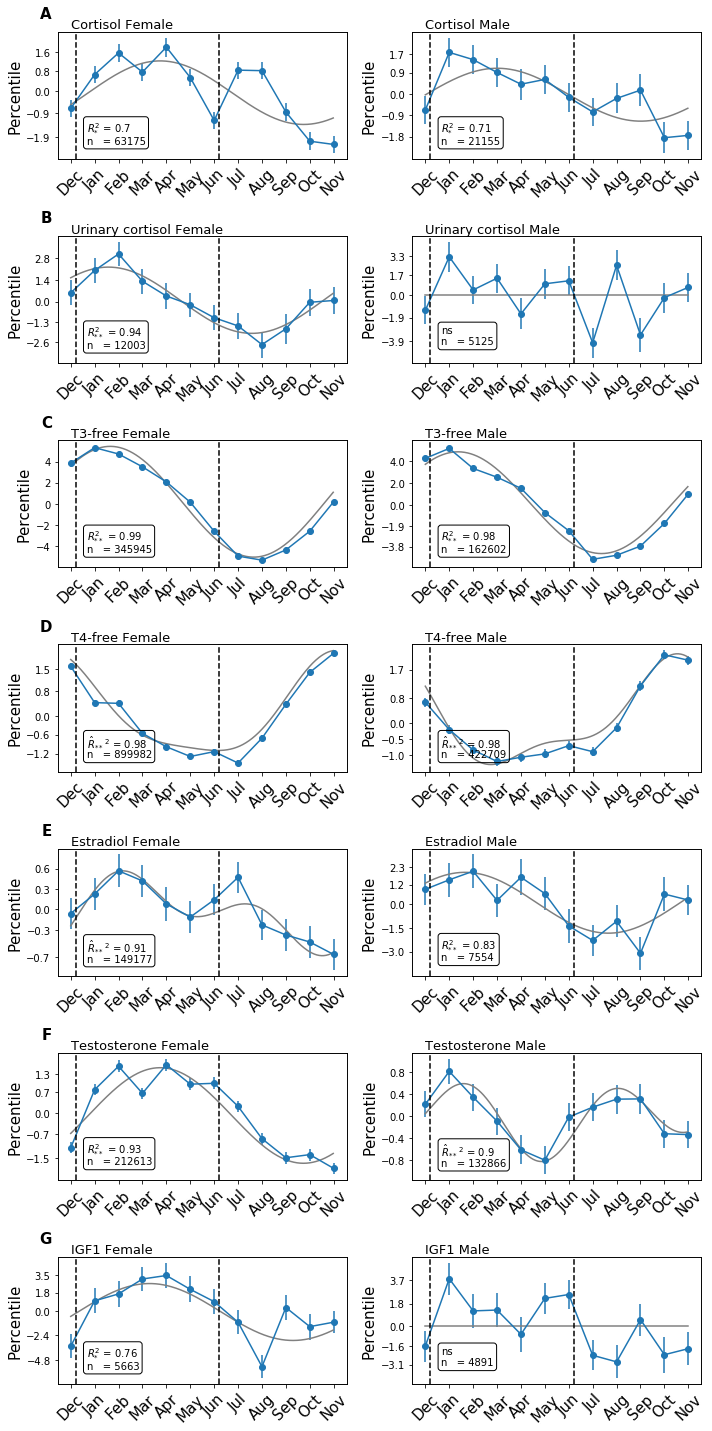

In [5]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]
                
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        y_percentage   = (yloc-yloc.mean())*100;
        err_precentage = err*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.savefig('../figures/Seasonality03022020/SI_effector_subplots_0302.png',bbox_inches='tight',dpi=600)
plt.show()

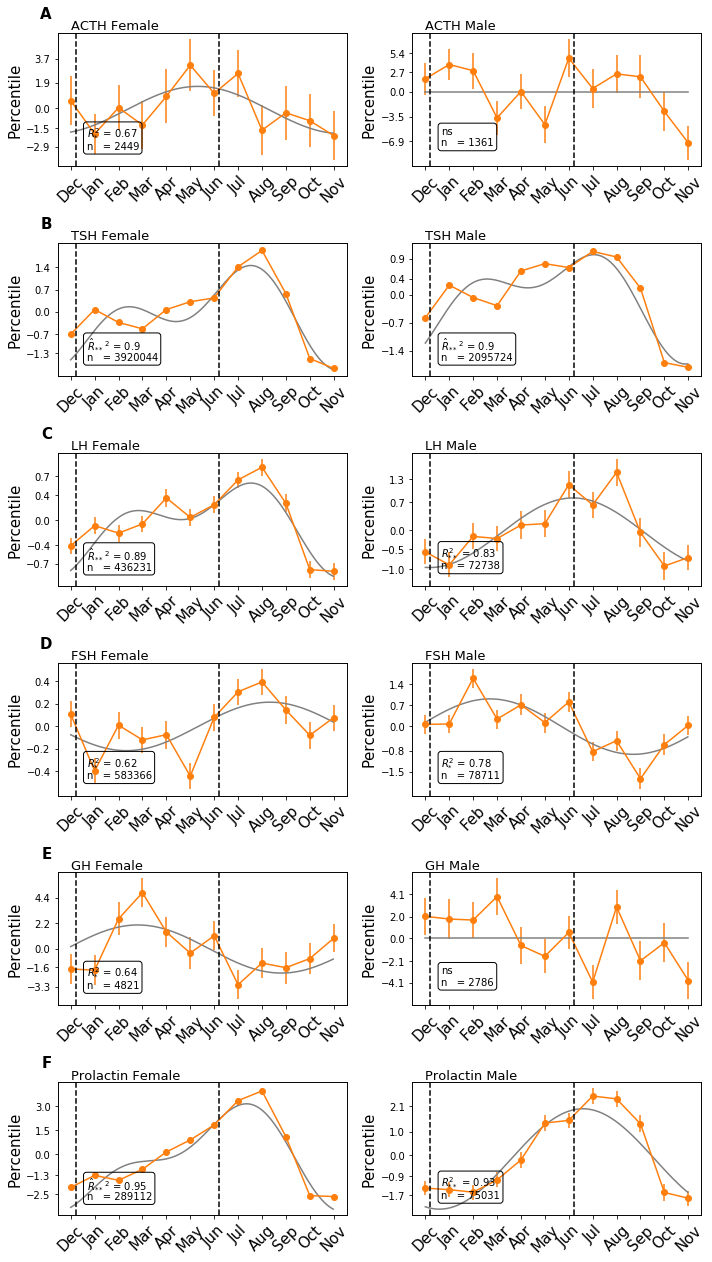

In [6]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
            
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100

        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.savefig('../figures/Seasonality03022020/SI_pituitary_subplots_0302.png',bbox_inches='tight',dpi=600)
plt.show()

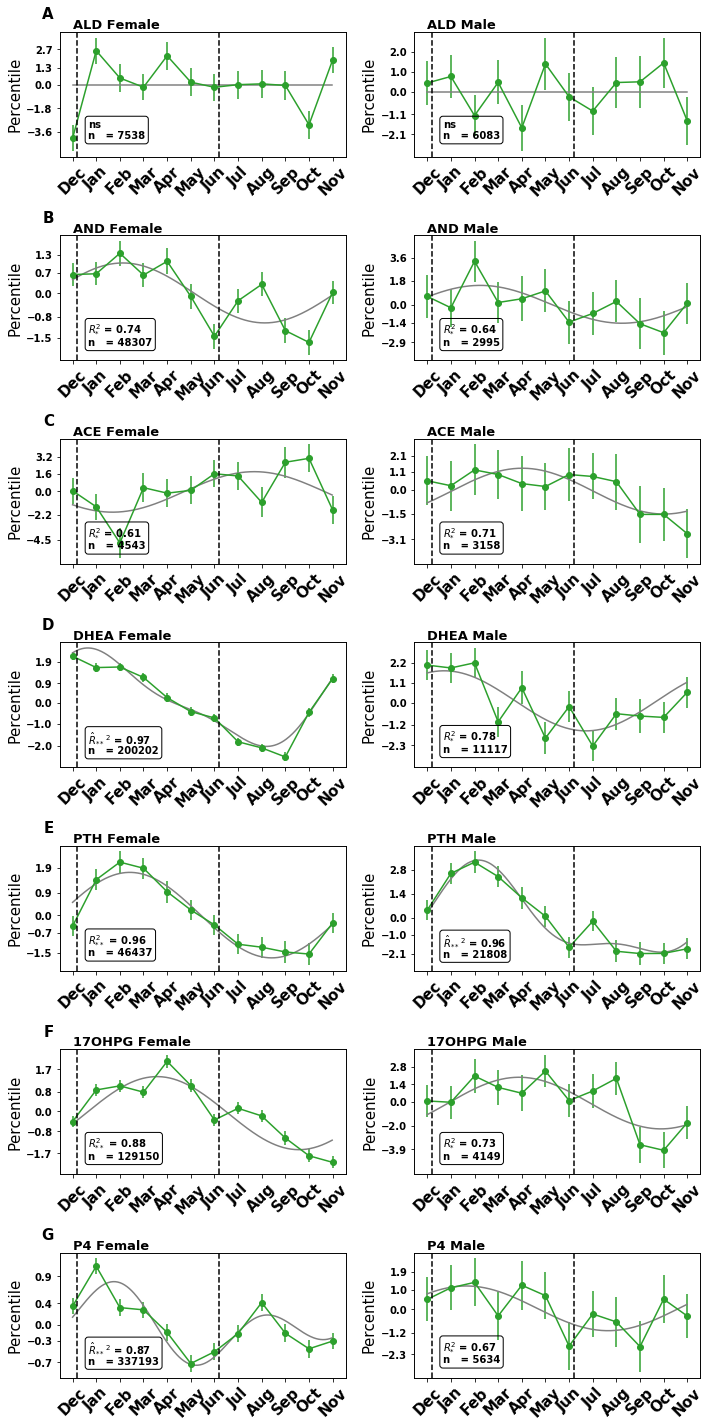

In [32]:
'''
plot residual hormones seasonality
'''
residual_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(residual_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = residual_list[residual_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        residual_r2df = residual_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100
        err_precentage = err*100

        #plot
        ax = plt.subplot(9,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[2],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(residual_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
         
plt.tight_layout()
# plt.savefig('../figures/Seasonality03022020/SI_residual_subplots_0302.png',bbox_inches='tight',dpi=600)
plt.show()

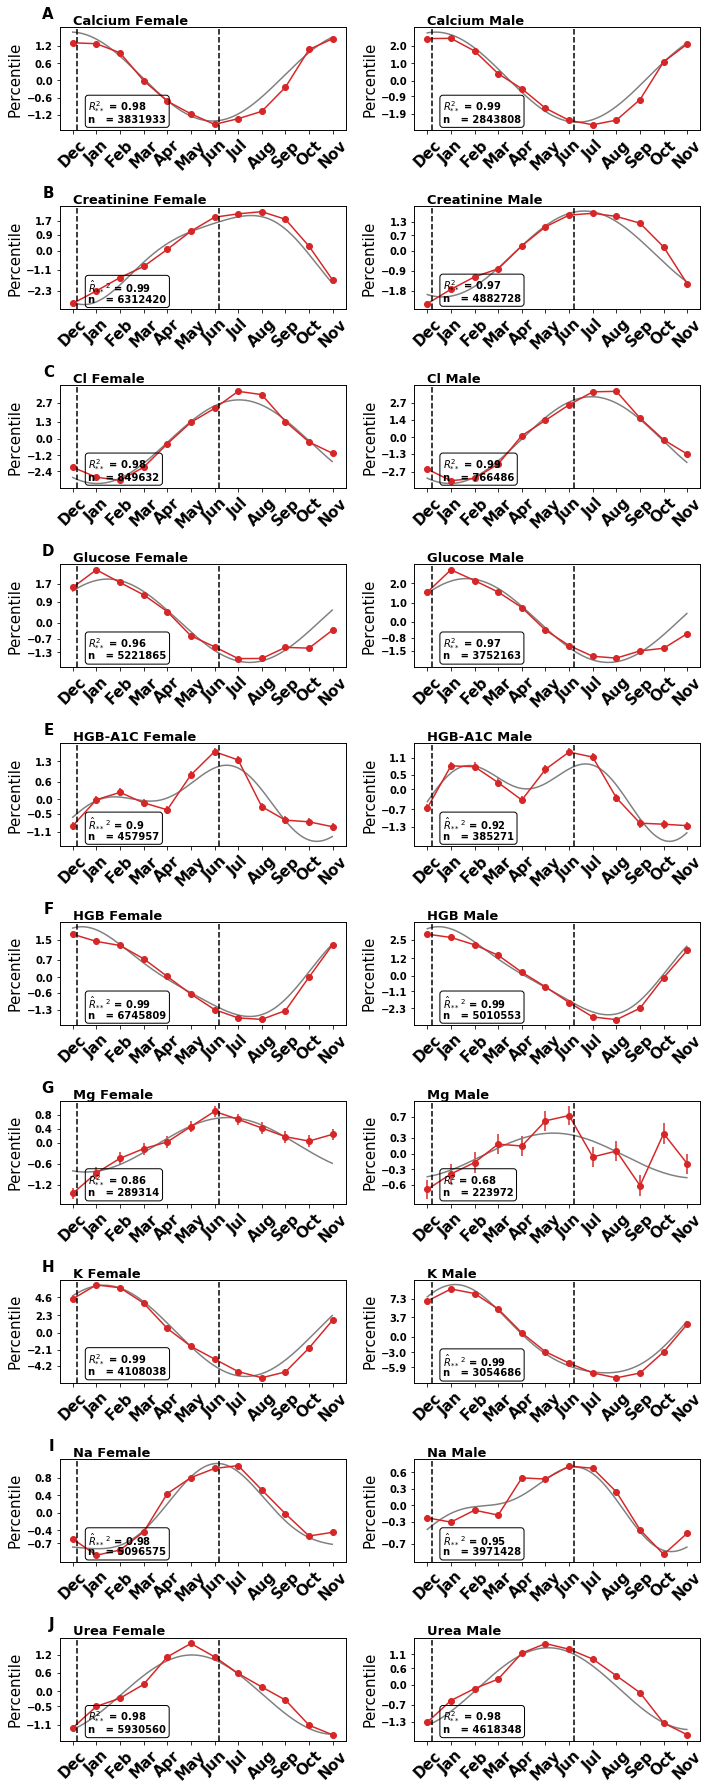

In [33]:
'''
plot chemistry seasonality
'''
chem_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(chem_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = chem_list[chem_dic[k]][sex]['Clalit']['xloc']
        yloc    = chem_list[chem_dic[k]][sex]['Clalit']['yloc']
        err     = chem_list[chem_dic[k]][sex]['Clalit']['err']
        ntot    = chem_list[chem_dic[k]][sex]['Clalit']['ntot']
        phase   = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][1]
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        chem_r2df = chem_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100
        #plot
        ax = plt.subplot(10,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[3],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(chem_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
       
plt.tight_layout()
plt.savefig('../figures/Seasonality03022020/SI_chemistry_subplots_0302.png',bbox_inches='tight',dpi=600)
plt.show()

# FIG 1 complete

In [26]:
def HPA_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cortisol',[-1.12+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.725, 0.2, 0.2], anchor='SW', zorder=-1)
    
    newax.imshow(plt.imread('../figures/ppt/glands/adrenal.png'))
    
    newax.text(0.2, 1.08, 'Stress adaptation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    
    newax.text(0.2, 0.2, 'Adrenal Cortex', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    

    newax.text(0.16, 1.09, 'A', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')

    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def HPT_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4'   ,[-1.015+xoff ,-0.8+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'   ,[-1.015+xoff ,-1.1+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.7 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.8 +Yoff],
                xy    =[-0.97  +xoff ,-1 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
       
    newax = fig.add_axes([-0.2, 0.528, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/thyroid.png'))
    
    newax.text(0.2, 1.08, 'Thermoregulation \n   & metabolism', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, 'Thyroid', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'B', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)
    
def HPG_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.9+xoff ,-0.15+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.9+xoff ,-0.35+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.357, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/gonads.png'))
    
    newax.text(0.2, 1.08, 'Reproduction', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, '  Gonads', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'C', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    

def HPL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.6     
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-1.05+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.133, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/liver.png'))
    
    newax.text(0.2, 1.08, 'Growth', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.56, '    Liver', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'D', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def PRL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.45 
    ax.annotate('H'    ,[-1   +xoff,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1   +xoff,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-1.05+xoff,-0.45+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, 0.3 +Yoff],
                xy    =[-0.97  +xoff,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, -0.1 +Yoff],
                xy    =[-0.97  +xoff,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))

    newax = fig.add_axes([-0.2, 0.035, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/breasts.png'))
    
    newax.text(0.2, 1.08, 'Lactation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.45, '    Breasts', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'E', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    
        
def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False,fontsize=15):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,mec='k')
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=fontsize)
    

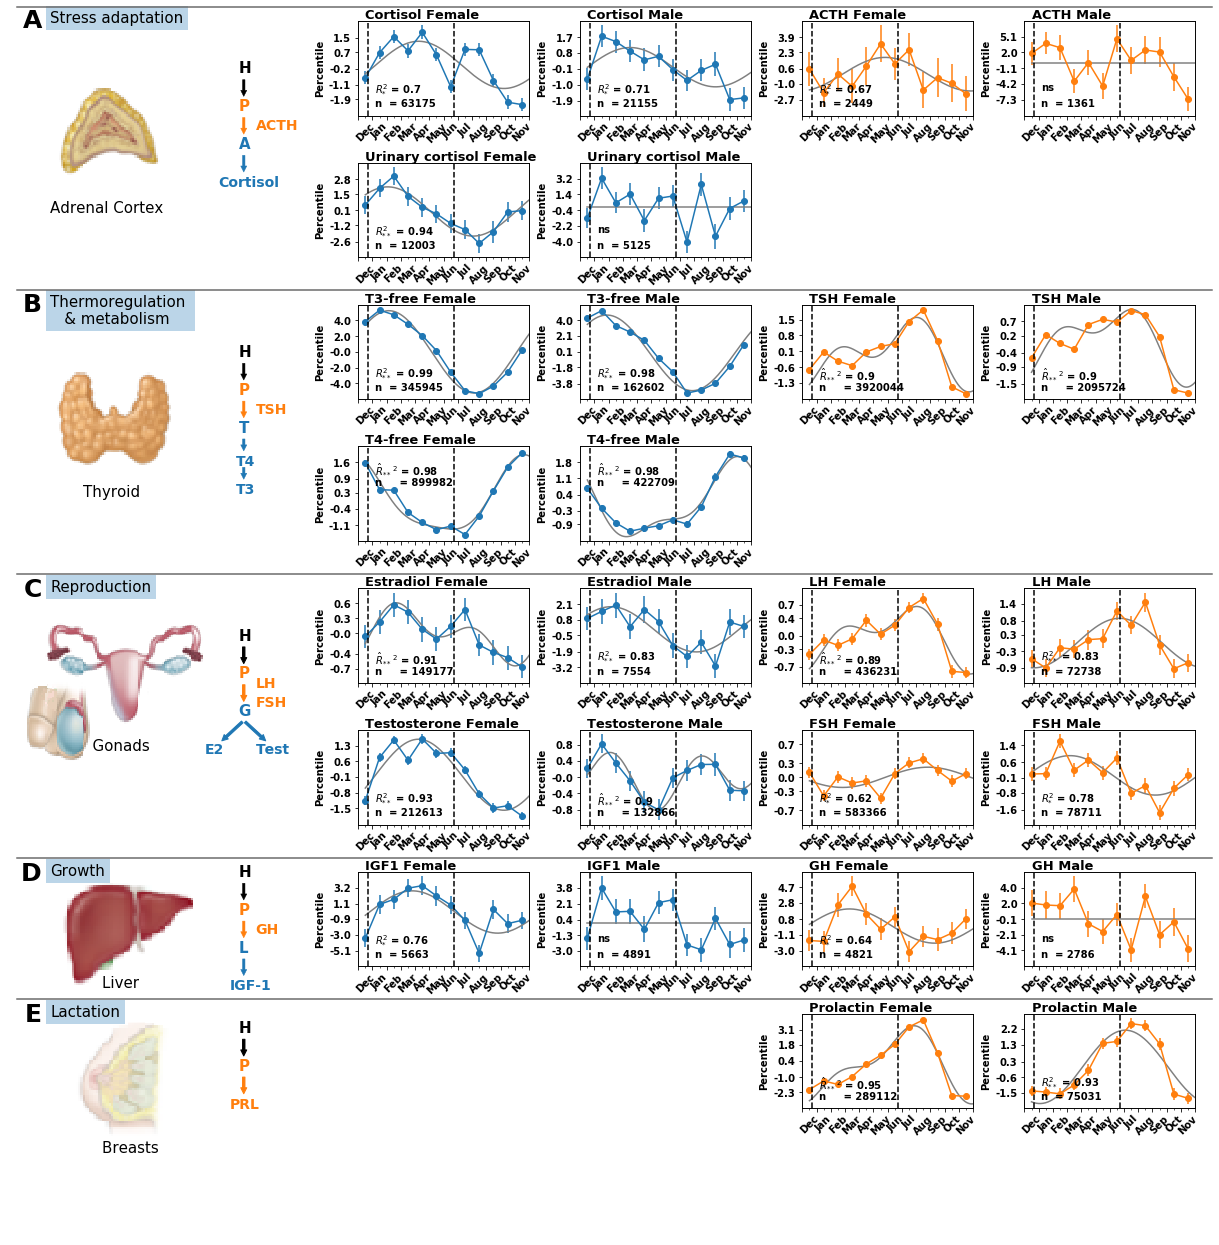

In [27]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[7,0]); PRL_graph_on_axe(ax,fig);  ax.axis('off')
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
           
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 
            
        if k == 'T4_FREE':
            ax.text(0.1, 0.85, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.675, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        else:
            ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)

        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100;  fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        if ax.get_ylim()[1]<0.7:
            ax.set_ylim([-1,1])
        
        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        
        axn = ax.twinx(); axn.set_yticks([]); 
        axn.axvline(x=0.2,ls='--',c='k'); axn.axvline(x=6.2,ls='--',c='k')
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 

        ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

plt.subplots_adjust(hspace=0.5,wspace =0.3)
# plt.savefig('../figures/Seasonality03022020/Figure1_0302.png',bbox_inches='tight',dpi=600)
plt.show()

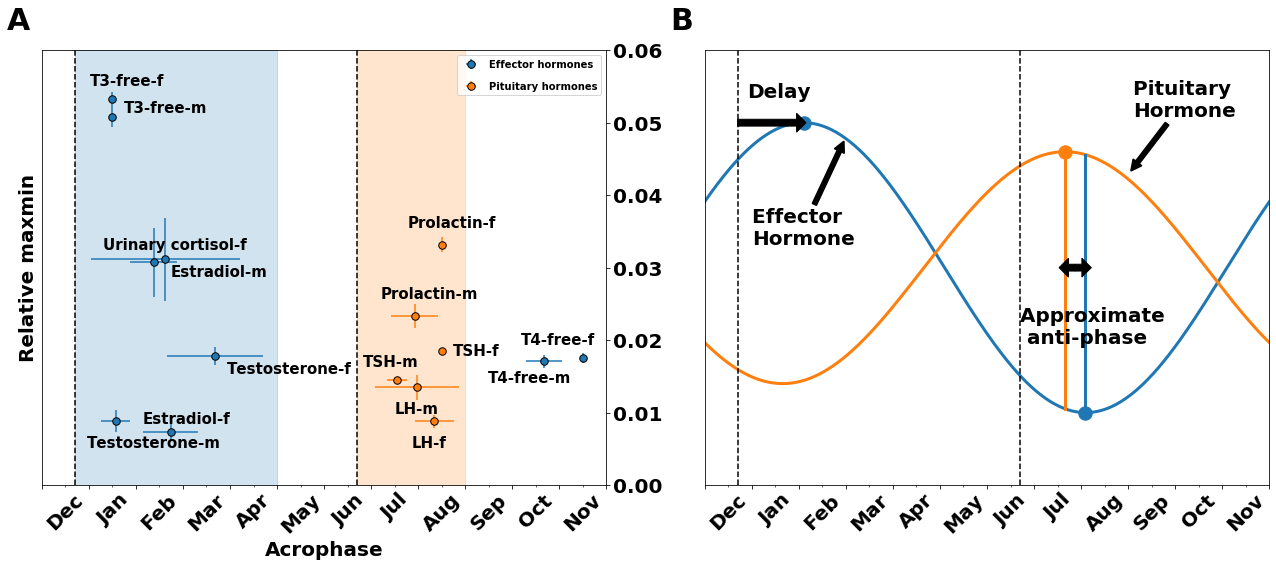

In [16]:
'''
FIG 2AB -  Code to phase plot, and summery
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(22,8))
gs  = fig.add_gridspec(4, 6)

uy = 0.06/100
ux = 12/100
pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
eff_loc = [(-9*ux,3*uy),(ux*-4,3*uy),(ux*2,1*uy),(-11*ux,3*uy),(-10*ux,-5*uy),(-5*ux,2*uy),(ux,-4*uy),(2*ux,-4*uy),(-5*ux,-6*uy),(-5*ux,4*uy)]

temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


'''
FIG 2A -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[:,:3])
ax    = fig.add_subplot(gs[:,3:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12))
axbig.set_xticklabels(month_names0, rotation=45)
axbig.tick_params(axis='x',labelsize =20)
axbig.tick_params(axis='y',labelsize =20)

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 4.5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,13,1)-0.5)
axbig.set_xticklabels([])
axbig.set_xticks(np.arange(0,12,1),minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)
axbig.set_xlim([-0.5,11.5])
###########################################
###########################################
###########################################

'''
FIG 2B -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = [] 
                                              
for j,hormone in enumerate(eff_big):
    name = hormone[0]
    if name in ['T3_FREE','T4_FREE']:
        continue
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])            
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]
    if name in ['TSH_THYROID_STIMULATING_HORMONE','GROWTH_HORMONE_GH','PROLACTIN']:
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3) 

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
# relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+0.8*relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])

ax.set_xticks(0.5+np.arange(12))
ax.set_xticklabels(mn, rotation=45)
ax.set_xlim([0,12])
ax.set_ylim([1-relmaxmin*1.5,1+relmaxmin*1.5])

ax.tick_params(axis='x',labelsize =20)

ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[0.9,1.0225],fontsize=20)

ax.annotate('Pituitary \nHormone',fontsize=20,
            xy=(9, pit_cos[9*30]), xycoords='data',
            xytext=(9.1, 1.02), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(3, eff_cos[3*30]), xycoords='data',
            xytext=(1, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

ax.annotate('Approximate \n anti-phase',[6.7,0.99],fontsize=20)

mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

ax.arrow(mid, 1, ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.arrow(mid, 1, -ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)

ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

ax.set_xticks(np.arange(0,13,1))
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)

plt.subplots_adjust(hspace=0.4,wspace =0.8)
plt.savefig('../figures/Seasonality03022020/Figure2_0302.png',bbox_inches='tight',dpi=600)
plt.show()

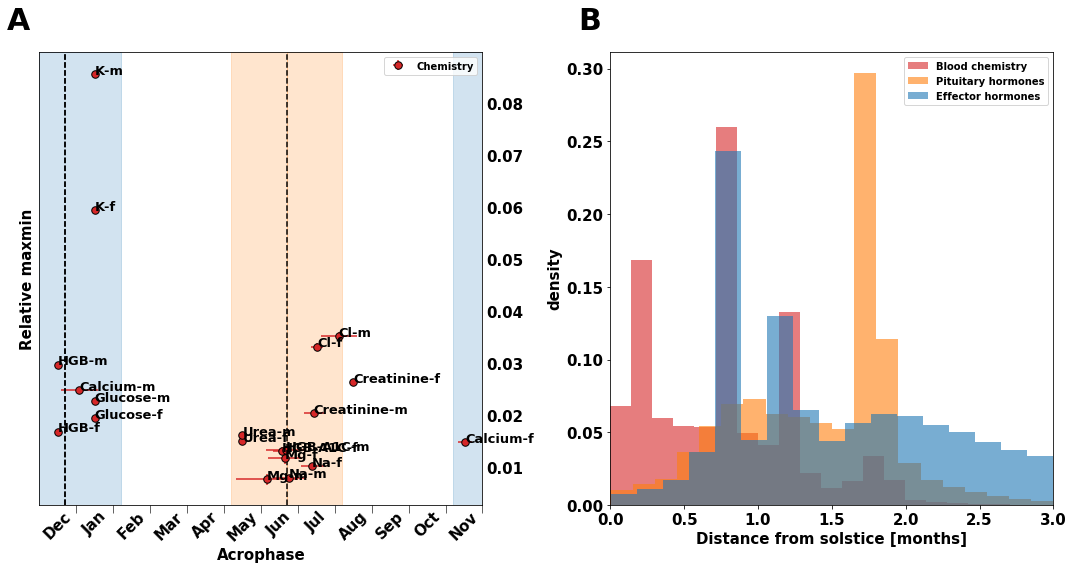

effector & chemistry,  Ks_2sampResult(statistic=0.44861666666666666, pvalue=0.0)
pituitary & chemistry,  Ks_2sampResult(statistic=0.2062222222222222, pvalue=6.025644307221098e-134)
Chem distance from solstice (mean, std) [0.7673928026462108, 0.48617615141540765]
Hormone distance from solstice (mean, std) [1.4503050847075423, 0.6424254812297705]


In [25]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(0,0),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
chem_loc = [(0,0) for i in chem_names] 

chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
# plt.show()

dec21 = 0.2
jun21 = 6.2
dec21B = 12.2
def distance_from_solstice(acrophases_list):
    return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

Dche = []; Deff = []; Dpit = []

for bootstrap in range(1000):
    chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
    Dche += distance_from_solstice(chem_acrophase_boot)

    eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
    Deff += distance_from_solstice(eff_acrophase_boot)
    
    pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
    Dpit += distance_from_solstice(pit_acrophase_boot)
   
eff_weights = np.ones_like(Deff)/float(len(Deff))
pit_weights = np.ones_like(Dpit)/float(len(Dpit))
che_weights = np.ones_like(Dche)/float(len(Dche))

ax1 = plt.subplot(1,2,2);
ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax1.hist(Dche,color=def_color[3],alpha=0.6,bins=20,weights=che_weights);
ax1.hist(Dpit,color=def_color[1],alpha=0.6,bins=20,weights=pit_weights);
ax1.hist(Deff,color=def_color[0],alpha=0.6,bins=20,weights=eff_weights); 
ax1.set_xlim([0,3])
ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
ax1.set_ylabel('density',fontsize=15,fontweight='bold')
ax1.tick_params(axis='x',labelsize =15)
ax1.tick_params(axis='y',labelsize =15)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.savefig('../figures/Seasonality03022020/SI_Chem_phase_amp_0302.png',bbox_inches='tight',dpi=600)
plt.show()

print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
print('pituitary & chemistry, ',stats.ks_2samp(Dpit, Deff))
print('Chem distance from solstice (mean, std)',[np.mean(Dche),np.std(Dche)])
print('Hormone distance from solstice (mean, std)',[np.mean(Dpit +Deff),np.std(Dpit +Deff)])

In [21]:
table = []
for key in pituitary_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [pituitary_list[key][sex]['Clalit']['ntot']] + [pituitary_list[key][sex]['Clalit']['yloc'].mean()] + [pituitary_list[key][sex]['Clalit']['err'].mean()] + pituitary_list[key][sex]['Cosinor']['pars'][0] + pituitary_list[key][sex]['Cosinor2']['pars'][0] + pituitary_list[key][sex]['Cosinor']['pars'][1] + pituitary_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df    = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])

table = []
for key in effector_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [effector_list[key][sex]['Clalit']['ntot']] + [effector_list[key][sex]['Clalit']['yloc'].mean()] + [effector_list[key][sex]['Clalit']['err'].mean()] + effector_list[key][sex]['Cosinor']['pars'][0] + effector_list[key][sex]['Cosinor2']['pars'][0] + effector_list[key][sex]['Cosinor']['pars'][1] + effector_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df2 = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])
df = pd.concat([df2,df])
df = df.drop(columns = ['acrophase2','maxmin2'])
print('Table S1')
display(df[['hormone','sex','n','M','Merr','phase','phase_std','amp','amp_std','phase2','phase2_std','amp2','amp2_std','maxmin','maxmin_std','acrophase','acrophase_std']])

Table S1


hormone     sex        n                    M  \
0           Cortisol  female    63175   0.5150220411982699   
1           Cortisol    male    21155   0.5116796376259668   
2   Urinary cortisol  female    12003   0.5138324409675353   
3   Urinary cortisol    male     5125   0.5080748844932872   
4            T3-free  female   345945   0.5070834315520638   
5            T3-free    male   162602   0.5051268886112837   
6            T4-free  female   899982    0.505828953146857   
7            T4-free    male   422709    0.504839463229084   
8          Estradiol  female   149177   0.5010414932237759   
9          Estradiol    male     7554   0.5038880124498989   
10      Testosterone  female   212613   0.5191111821232659   
11      Testosterone    male   132866   0.5137470698190655   
12              IGF1  female     5663  0.49813342139975875   
13              IGF1    male     4891   0.4977259385458717   
0               ACTH  female     2449   0.5046907930781128   
1               ACTH    male     1361   0.5080789197557996   
2                TSH  female  3920044   0.4981084526555817   
3                TSH    male  2095724   0.4962083470601752   
4                 LH  female   436231  0.48925459486533834   
5                 LH    male    72738  0.49794083119461335   
6                FSH  female   583366   0.4940669192732631   
7                FSH    male    78711   0.5001143323665085   
8                 GH  female     4821   0.5082302494285297   
9                 GH    male     2786   0.5397307090817339   
10         Prolactin  female   289112     0.50917017251982   
11         Prolactin    male    75031   0.5092413545937766   

                     Merr                phase             phase_std  \
0    0.003655577234869425   3.7403234979593014   0.22077049927401102   
1    0.006296470639523169   3.0087623199012556     0.468638745298814   
2    0.008267326643619231    1.576236492229329    0.2895195638395426   
3     0.01259645609657826                 -1.0                   0.0   
4   0.0015245368836001288   1.6526243937095701  0.022692144849682367   
5   0.0022235288861987327   1.3682803252784699   0.03694564437524368   
6   0.0009633870720264936  -0.7372839081274816  0.047622512866777135   
7   0.0013972114711589196   10.151932663736293   0.07022166650420807   
8   0.0023401167531657487   3.4714696529275564    0.4781793927067716   
9    0.010420630517734479    1.658592696682061   0.44230251837345236   
10   0.001968024718746526     3.73419152382825   0.09036450542547042   
11   0.002530262719731537  -0.8634064467275191     0.941904611682847   
12   0.012059687529978944     3.29606149360981    0.3414939410850155   
13   0.013022928145374292                 -1.0                   0.0   
0     0.01834106031188289    5.316289364090193     1.042918636088899   
1    0.025412685768355647                 -1.0                   0.0   
2   0.0004593829175048804    6.242976166552746   0.03562226455006447   
3   0.0006253106520747643    5.331263143702517   0.04748888919488531   
4   0.0013660095003182736     5.94795211634377   0.20307250066009913   
5   0.0033629576350561376    6.182761995337766    0.3098609307134905   
6   0.0011851068328058091    8.328820707258245   0.45777342027122414   
7      0.0032385065141326   2.7057358273434002   0.28009575675261333   
8    0.013016722063107717   2.8078539868225714    0.5273352027995396   
9    0.016750750368910668                 -1.0                   0.0   
10  0.0016767439749519697     6.43928609741057   0.05084438066161887   
11  0.0033108297451698234    6.589560486017916   0.12283308008540209   

                      amp                 amp_std              phase2  \
0    0.012988774593442628   0.0015926724425104931                -1.0   
1    0.011157938587287048    0.002650094447709264                -1.0   
2    0.021313214934701678   0.0032528749298844383                -1.0   
3                     0.0                     0.0                -1.0   
4    0.052409506963370475   